In [80]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# import PIL

In [81]:
# %load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# %tensorboard --logdir logs

In [82]:
# # For Google Colab Only
# # Mount GDrive
# from google.colab import drive

# drive.mount("/content/drive")

In [83]:
# # For Google Colab Only
# # Put Colab in the context of this challenge

# # os.chdir allows you to change directories, like cd in the Terminal
# os.chdir("/content/drive/MyDrive/Colab Notebooks/CXRay/notebooks")

In [ ]:
# # For Google Colab Only
# # If caching to disk instead of RAM:
# !mkdir tmp

In [ ]:
IMG_SOURCE = "GS" # Enter "GS" for Google Cloud storage bucket or "local" to read from the local disk

# Data Pre-Processing

In [84]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "clean_data", "cleaned_data.csv")

data = pd.read_csv(data_path)
data.head()

,img_idx,labels,age,gender,view_pos,label_cardiomegaly,label_effusion,label_no_finding,label_pneumothorax,label_pleural_thickening,label_pneumonia,label_consolidation,label_other
0,00000001_000.png,Cardiomegaly,58,M,PA,True,False,False,False,False,False,False,False
1,00000001_001.png,Cardiomegaly|Emphysema,58,M,PA,True,False,False,False,False,False,False,True
2,00000001_002.png,Cardiomegaly|Effusion,58,M,PA,True,True,False,False,False,False,False,False
3,00000002_000.png,No Finding,81,M,PA,False,False,True,False,False,False,False,False
4,00000003_000.png,Hernia,81,F,PA,False,False,False,False,False,False,False,True


In [85]:
# data = data.drop(columns="label_other")
data = data.drop(columns="label_no_finding")
data.shape

(112104, 12)

In [86]:
label_names = [l for l in data.columns if l.startswith("label_")]
label_names

['label_cardiomegaly',
 'label_effusion',
 'label_pneumothorax',
 'label_pleural_thickening',
 'label_pneumonia',
 'label_consolidation',
 'label_other']

In [87]:
data_pa = data.query("view_pos == 'PA'").copy()
data_pa[label_names].sum(axis=0).sort_values()

label_pneumonia               630
label_consolidation          1521
label_cardiomegaly           1563
label_pleural_thickening     2418
label_pneumothorax           3406
label_effusion               6589
label_other                 21132
dtype: int64

In [88]:
data_pa.shape

(67299, 12)

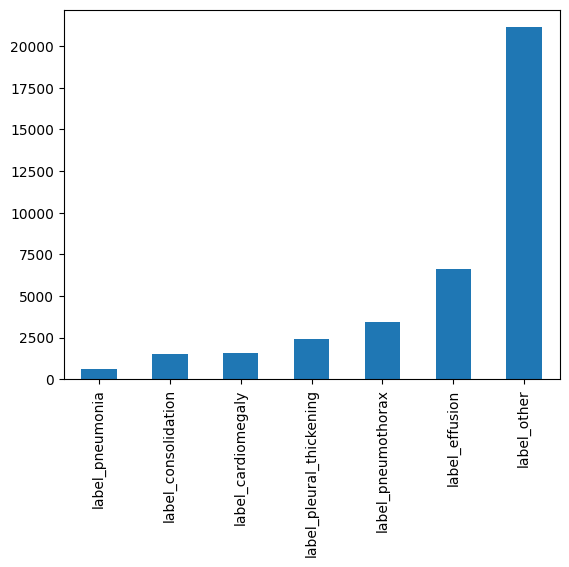

In [89]:
data_pa[label_names].sum(axis=0).sort_values().plot(kind="bar");

In [90]:
if "label_no_finding" not in label_names:
    n_patients_not_healthy = data_pa[np.sum(data_pa[label_names], axis=1) != 0].shape[0]
    print(f"{n_patients_not_healthy = }")
    n_patients_healthy = data_pa[np.sum(data_pa[label_names], axis=1) == 0].shape[0]
    print(f"{n_patients_healthy = }")
    print(
        "Percentage of healthy patients in all PA data:"
        f" {n_patients_healthy / data_pa.shape[0]:.2%}"
    )

n_patients_not_healthy = 28003
n_patients_healthy = 39296
Percentage of healthy patients in all PA data: 58.39%


In [91]:
label_counts_sorted = data_pa[label_names].sum(axis=0).sort_values()
print("Percentages of each condition:\n")
display((label_counts_sorted / data_pa.shape[0]).apply(lambda x: f"{x:.2%}"))
print(
    "\nNOTE: The percentages will add up to more than 100% as each patient can have"
    " multiple afflictions at the same time (except for 'no finding')."
)

Percentages of each condition:



label_pneumonia              0.94%
label_consolidation          2.26%
label_cardiomegaly           2.32%
label_pleural_thickening     3.59%
label_pneumothorax           5.06%
label_effusion               9.79%
label_other                 31.40%
dtype: object


NOTE: The percentages will add up to more than 100% as each patient can have multiple afflictions at the same time (except for 'no finding').


In [92]:
data_train_and_cv = data_pa.sample(frac=0.9)
data_train_and_cv.shape

(60569, 12)

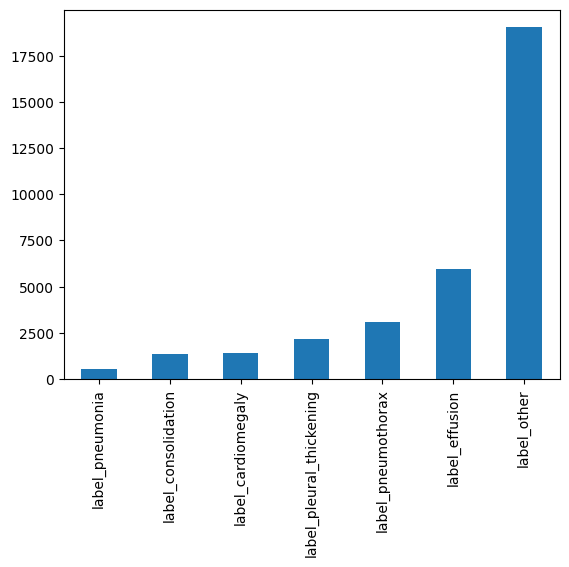

In [93]:
data_train_and_cv[label_names].sum(axis=0).sort_values().plot(kind="bar");

In [94]:
if "label_no_finding" not in label_names:
    n_patients_not_healthy = data_train_and_cv[
        np.sum(data_train_and_cv[label_names], axis=1) != 0
    ].shape[0]
    # print(f"{n_patients_not_healthy = }")
    n_patients_healthy = data_train_and_cv[
        np.sum(data_train_and_cv[label_names], axis=1) == 0
    ].shape[0]
    # print(f"{n_patients_healthy = }")
    print(
        "Percentage of healthy patients in train/cv PA data:"
        f" {n_patients_healthy / data_train_and_cv.shape[0]:.2%}"
    )

Percentage of healthy patients in train/cv PA data: 58.34%


In [95]:
label_counts_sorted = data_train_and_cv[label_names].sum(axis=0).sort_values()
print("Percentages of each condition in the training/cross-validation dataset:\n")
display((label_counts_sorted / data_train_and_cv.shape[0]).apply(lambda x: f"{x:.2%}"))

Percentages of each condition in the training/cross-validation dataset:



label_pneumonia              0.92%
label_consolidation          2.27%
label_cardiomegaly           2.33%
label_pleural_thickening     3.61%
label_pneumothorax           5.08%
label_effusion               9.80%
label_other                 31.44%
dtype: object

We can use the remaining (i.e. not selected) data for our test set later on...

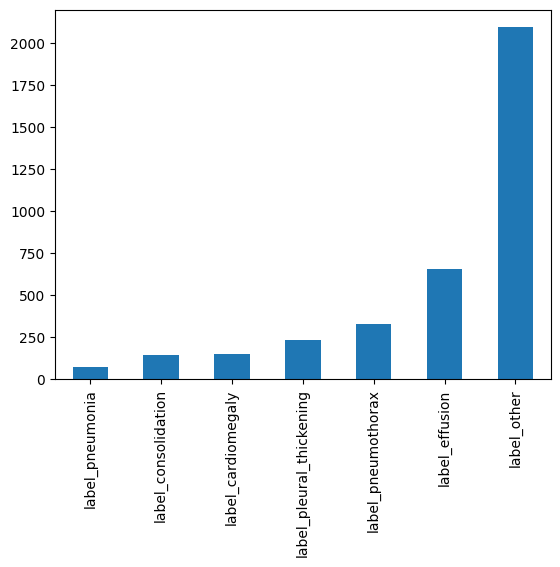

In [96]:
remaining_indices = data_pa.index.difference(data_train_and_cv.index)
remaining_data = data_pa.loc[remaining_indices]
remaining_data[label_names].sum(axis=0).sort_values().plot(kind="bar");

In [98]:
if "label_no_finding" not in label_names:
    n_patients_not_healthy = remaining_data[
        np.sum(remaining_data[label_names], axis=1) != 0
    ].shape[0]
    # print(f"{n_patients_not_healthy = }")
    n_patients_healthy = remaining_data[
        np.sum(remaining_data[label_names], axis=1) == 0
    ].shape[0]
    # print(f"{n_patients_healthy = }")
    print(
        "Percentage of healthy patients in train/cv PA data:"
        f" {n_patients_healthy / remaining_data.shape[0]:.2%}"
    )

Percentage of healthy patients in train/cv PA data: 58.86%


In [99]:
label_counts_sorted = remaining_data[label_names].sum(axis=0).sort_values()
print("Percentages of each condition in the testing dataset:\n")
display((label_counts_sorted / remaining_data.shape[0]).apply(lambda x: f"{x:.2%}"))

Percentages of each condition in the testing dataset:



label_pneumonia              1.08%
label_consolidation          2.14%
label_cardiomegaly           2.23%
label_pleural_thickening     3.42%
label_pneumothorax           4.86%
label_effusion               9.73%
label_other                 31.08%
dtype: object

In [100]:
remaining_data[label_names].sum(axis=0).sort_values().sum()

3671

In [101]:
remaining_data.shape

(6730, 12)

# Loading the Images

## Generating the Dataset on the Fly

It turns out [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is deprecated and hence not recommended for new code. Neither it nor its successor, [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) are really applicable to our multi-label problem. (They are suited to single-label classification problems). I found [this blog post](https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72) on how to leverage the underlying API, [`tf.data`](https://www.tensorflow.org/guide/data) for multi-label problems. Let us explore that.

In [102]:
# In order to do 'transfer learning' using VGG16, ResNet, etc. our image needs to have three channels.
# We will simply duplicate the one grayscale channel 2 more times.
def expand_greyscale_image_channels(image):
    if image.shape[-1] == 1:
        grey_image_3_channel = tf.tile(image, tf.constant([1, 1, 3], tf.int32))
    else:
        grey_image_3_channel = image

    return tf.keras.applications.mobilenet_v2.preprocess_input(grey_image_3_channel)

In [103]:
IMG_SIZE = 224  # img_dims[0]
CHANNELS = 3  # The images WERE grayscale but we converted them to 3-channel


def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    if IMG_SOURCE == "GS":
        filepath = "gs://cxray-bucket/images_224_224/" + filename
        image_string = tf.io.read_file(filepath)
    elif IMG_SOURCE == "local":
        image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = (
        image_decoded  # tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    )
    # If necessary, normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = tf.cast(
        image_resized, tf.float32
    )  # / 255.0 (the scaling/"normalization" step is actually taken care of by `preprocess_input()` above)
    image_normalized_rgb = expand_greyscale_image_channels(image_normalized)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.uint8)
    return image_normalized_rgb, label_tensor

In [104]:
# cwd = os.getcwd()
# data_dir = pathlib.Path(cwd, "..", "raw_data", "images_224_224")

# This works
img_norm_rgb, label_tensor = parse_function(
    "00000009_000.png",  # str(pathlib.Path(data_dir, "00000009_000.png")),
    np.array([True, False, False, True]) + 0,
)
img_norm_rgb.shape

TensorShape([224, 224, 3])

In [105]:
BATCH_SIZE = 256  # 256  # 256 is big enough to measure an F1-score but if running locally, this will likely crash due to insufficient RAM
AUTOTUNE = (
    tf.data.experimental.AUTOTUNE
)  # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = (
    1024  # 1024  # Shuffle the training data by a chunck of 1024 observations
)

N_LABELS = len(label_names)

In [106]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = (
            dataset.cache()
        )  # ("/content/tmp/") # If training locally, reduce batch size or else you'll run out of RAM.
        # If on Colab: caching to disk appears to be as fast as caching to RAM, at least on Premium. Your choice.
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [107]:
filenames = data_train_and_cv.img_idx.to_list()
filepaths = (
    filenames  # [str(pathlib.Path(data_dir, filename)) for filename in filenames]
)
label_sets_binarized = np.array(
    data_train_and_cv[label_names].apply(lambda x: x + 0), dtype=np.uint8
)

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_bin, y_val_bin = train_test_split(
    filepaths, label_sets_binarized, test_size=0.2
)

In [109]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

We now, finally, have our training and validation data sets with the correct tensor sizes and data types.  
Now let's create the test set from the data that was _not_ selected while creating the balanced dataset. (Stored in `remaining_data`)

In [110]:
test_data = remaining_data

test_data[label_names].sum(axis=0).sort_values()

label_pneumonia               73
label_consolidation          144
label_cardiomegaly           150
label_pleural_thickening     230
label_pneumothorax           327
label_effusion               655
label_other                 2092
dtype: int64

In [111]:
filenames_test = test_data.img_idx.to_list()
X_test = filenames_test  # [str(pathlib.Path(data_dir, filename)) for filename in filenames_test]
y_test_bin = np.array(test_data[label_names].apply(lambda x: x + 0), dtype=np.uint8)
test_ds = create_dataset(X_test, y_test_bin)

# Modelling

## Loss Function and Evaluation Metrics

The function below, from [the Medium post mentioned earlier](https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72), will provide our evaluation metric:

In [55]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)

    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive

    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

And the one below, from a related blog post ([here](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d)), provides a differentiable version of the above, for our loss function:

In [56]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.

    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)

    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    cost = 1 - soft_f1  # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost)  # average on all labels

    return macro_cost

## Baseline Model

We need _something_ to compare our eventual model's evaluation metrics to.  
Let us explore this further now.

### Naive baseline #1: Most-Frequent

What if we just predicted the most frequent class, i.e. naively predict that all patients are healthy?

In [57]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    multilabel_confusion_matrix,
)

In [58]:
y_test_bin

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [59]:
pred_all_healthy = np.zeros(y_test_bin.shape, dtype=np.float32)
pred_all_healthy[:, 2] = 1  # 2 is the index of "no finding"
macro_f1(y_test_bin, pred_all_healthy)

<tf.Tensor: shape=(), dtype=float32, numpy=0.092492044>

In [60]:
print(classification_report(y_test_bin, pred_all_healthy, target_names=label_names))

                          precision    recall  f1-score   support

      label_cardiomegaly       0.00      0.00      0.00       151
          label_effusion       0.00      0.00      0.00       665
        label_no_finding       0.59      1.00      0.74      3952
      label_pneumothorax       0.00      0.00      0.00       337
label_pleural_thickening       0.00      0.00      0.00       250
         label_pneumonia       0.00      0.00      0.00        65
     label_consolidation       0.00      0.00      0.00       146
             label_other       0.00      0.00      0.00      2071

               micro avg       0.59      0.52      0.55      7637
               macro avg       0.07      0.12      0.09      7637
            weighted avg       0.30      0.52      0.38      7637
             samples avg       0.59      0.59      0.59      7637



/Users/fafa/.pyenv/versions/3.10.6/envs/cxray/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
multilabel_confusion_matrix(y_test_bin, pred_all_healthy)

array([[[6579,    0],
        [ 151,    0]],

       [[6065,    0],
        [ 665,    0]],

       [[   0, 2778],
        [   0, 3952]],

       [[6393,    0],
        [ 337,    0]],

       [[6480,    0],
        [ 250,    0]],

       [[6665,    0],
        [  65,    0]],

       [[6584,    0],
        [ 146,    0]],

       [[4659,    0],
        [2071,    0]]])

In [62]:
accuracy_score(y_test_bin, pred_all_healthy)

0.587221396731055

The classification report scores are not very helpful in this scenario...  
What if we predicted the most frequent ailment, i.e. naively predict that all patients have one of the "other" ailments (other than the main 6 we're focusing on)?

In [123]:
pred_all_other = np.zeros(y_test_bin.shape, dtype=np.float32)
pred_all_other[:, -1] = 1  # "label_other" is the last label
macro_f1(y_test_bin, pred_all_other)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0677527>

In [124]:
print(classification_report(y_test_bin, pred_all_other, target_names=label_names))

                          precision    recall  f1-score   support

      label_cardiomegaly       0.00      0.00      0.00       150
          label_effusion       0.00      0.00      0.00       655
      label_pneumothorax       0.00      0.00      0.00       327
label_pleural_thickening       0.00      0.00      0.00       230
         label_pneumonia       0.00      0.00      0.00        73
     label_consolidation       0.00      0.00      0.00       144
             label_other       0.31      1.00      0.47      2092

               micro avg       0.31      0.57      0.40      3671
               macro avg       0.04      0.14      0.07      3671
            weighted avg       0.18      0.57      0.27      3671
             samples avg       0.31      0.26      0.28      3671



/Users/fafa/.pyenv/versions/3.10.6/envs/cxray/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fafa/.pyenv/versions/3.10.6/envs/cxray/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
multilabel_confusion_matrix(y_test_bin, pred_all_other)

array([[[6580,    0],
        [ 150,    0]],

       [[6075,    0],
        [ 655,    0]],

       [[6403,    0],
        [ 327,    0]],

       [[6500,    0],
        [ 230,    0]],

       [[6657,    0],
        [  73,    0]],

       [[6586,    0],
        [ 144,    0]],

       [[   0, 4638],
        [   0, 2092]]])

In [126]:
accuracy_score(y_test_bin, pred_all_other)

0.2175334323922734

### Naive Baseline #2: Maximum Recall

What if we assumed all patients have all the ailments?!

In [127]:
pred_all_ones = np.ones(y_test_bin.shape, dtype=np.float32)
macro_f1(y_test_bin, pred_all_ones)

<tf.Tensor: shape=(), dtype=float32, numpy=0.13105488>

In [128]:
print(classification_report(y_test_bin, pred_all_ones, target_names=label_names))

                          precision    recall  f1-score   support

      label_cardiomegaly       0.02      1.00      0.04       150
          label_effusion       0.10      1.00      0.18       655
      label_pneumothorax       0.05      1.00      0.09       327
label_pleural_thickening       0.03      1.00      0.07       230
         label_pneumonia       0.01      1.00      0.02        73
     label_consolidation       0.02      1.00      0.04       144
             label_other       0.31      1.00      0.47      2092

               micro avg       0.08      1.00      0.14      3671
               macro avg       0.08      1.00      0.13      3671
            weighted avg       0.20      1.00      0.32      3671
             samples avg       0.08      0.41      0.13      3671



/Users/fafa/.pyenv/versions/3.10.6/envs/cxray/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
multilabel_confusion_matrix(y_test_bin, pred_all_ones)

array([[[   0, 6580],
        [   0,  150]],

       [[   0, 6075],
        [   0,  655]],

       [[   0, 6403],
        [   0,  327]],

       [[   0, 6500],
        [   0,  230]],

       [[   0, 6657],
        [   0,   73]],

       [[   0, 6586],
        [   0,  144]],

       [[   0, 4638],
        [   0, 2092]]])

In [130]:
accuracy_score(y_test_bin, pred_all_ones)

0.0

**A note on Accuracy:** Accuracy is not very meaningful as an aggregate evaluation metric for our multilabel classification problem. Even if one of the multiple conditions are classified incorrectly, that patient will contribute a zero for the overall accuracy score. That makes the above accuracy score impossible to beat. We can, instead, talk about per-label accuracy however. And we will investigate this later if time allows.

### Naive Baseline #3: Random based on frequency

What if we randomly predicted the conditions based on their frequencies of occurrence?  

In [63]:
label_ratios = data_train_and_cv[label_names].sum(axis=0) / len(data_train_and_cv)
label_ratios

label_cardiomegaly          0.023312
label_effusion              0.097806
label_no_finding            0.583533
label_pneumothorax          0.050669
label_pleural_thickening    0.035794
label_pneumonia             0.009328
label_consolidation         0.022701
label_other                 0.314699
dtype: float64

In [64]:
pred_random_label_counts = (y_test_bin.shape[0] * label_ratios).apply(lambda x: int(x))
pred_random_label_counts

label_cardiomegaly           156
label_effusion               658
label_no_finding            3927
label_pneumothorax           341
label_pleural_thickening     240
label_pneumonia               62
label_consolidation          152
label_other                 2117
dtype: int64

In [65]:
pred_random = np.zeros(y_test_bin.shape)

for i, label in enumerate(label_names):
    pred_random[
        np.random.choice(
            pred_random.shape[0], int(pred_random_label_counts[label]), replace=False
        ),
        i,
    ] = 1

# pred_random.sum(axis=0)
macro_f1(y_test_bin, pred_random)

<tf.Tensor: shape=(), dtype=float32, numpy=0.13926691>

In [66]:
print(classification_report(y_test_bin, pred_random, target_names=label_names))

                          precision    recall  f1-score   support

      label_cardiomegaly       0.03      0.03      0.03       151
          label_effusion       0.10      0.10      0.10       665
        label_no_finding       0.58      0.58      0.58      3952
      label_pneumothorax       0.04      0.04      0.04       337
label_pleural_thickening       0.03      0.02      0.02       250
         label_pneumonia       0.02      0.02      0.02        65
     label_consolidation       0.01      0.01      0.01       146
             label_other       0.32      0.32      0.32      2071

               micro avg       0.40      0.40      0.40      7637
               macro avg       0.14      0.14      0.14      7637
            weighted avg       0.40      0.40      0.40      7637
             samples avg       0.33      0.43      0.36      7637



/Users/fafa/.pyenv/versions/3.10.6/envs/cxray/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
multilabel_confusion_matrix(y_test_bin, pred_random)

array([[[6427,  152],
        [ 147,    4]],

       [[5472,  593],
        [ 600,   65]],

       [[1146, 1632],
        [1657, 2295]],

       [[6066,  327],
        [ 323,   14]],

       [[6246,  234],
        [ 244,    6]],

       [[6604,   61],
        [  64,    1]],

       [[6433,  151],
        [ 145,    1]],

       [[3210, 1449],
        [1403,  668]]])

In [68]:
accuracy_score(y_test_bin, pred_random)

0.2010401188707281

## Transfer Learning

We will be performing transfer learning using one of the many available pre-trained deep convolutional neural networks such as those listed in [this paper](https://www.nature.com/articles/s41598-020-70479-z.pdf?origin=ppubhttps://www.nature.com/articles/s41598-020-70479-z.pdf?origin=ppub).

In [69]:
LR = 1e-5  # For transfer learning, use a small value such as 1e5
EPOCHS = 200
DO1 = 0.4
DO2 = 0.2
DO3 = 0.1
L2_REG = 0.001
pretrained_model = "MobileNetV2"


def get_pretrained_model():
    pretrained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
    )
    pretrained_model.trainable = False
    return pretrained_model

In [70]:
# pretrained = get_pretrained_model()
# pretrained.summary()

In [71]:
def create_compiled_custom_model():
    base_model = get_pretrained_model()
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(
        200, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG)
    )
    dropout_layer_1 = tf.keras.layers.Dropout(DO1)
    dense_layer_2 = tf.keras.layers.Dense(
        100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG)
    )
    dropout_layer_2 = tf.keras.layers.Dropout(DO2)
    dense_layer_3 = tf.keras.layers.Dense(
        50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG)
    )
    dropout_layer_3 = tf.keras.layers.Dropout(DO3)
    prediction_layer = tf.keras.layers.Dense(N_LABELS, activation="sigmoid")

    model = tf.keras.models.Sequential(
        [
            base_model,
            flattening_layer,
            dense_layer_1,
            dropout_layer_1,
            dense_layer_2,
            dropout_layer_2,
            dense_layer_3,
            dropout_layer_3,
            prediction_layer,
        ]
    )

    opt = tf.keras.optimizers.Adam(learning_rate=LR)

    model.compile(
        optimizer=opt,
        loss=macro_soft_f1,
        metrics=["accuracy", macro_f1],
    )

    return model

In [72]:
test_model = create_compiled_custom_model()
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 200)               12544200  
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                      

In [73]:
filename = f"test_model_{pretrained_model}_bs{BATCH_SIZE}_lr{LR}_do{DO1}-{DO2}-{DO3}_l2-{L2_REG}(Mac).h5"
filename

'test_model_MobileNetV2_bs256_lr1e-05_do0.4-0.2-0.1_l2-0.001(Mac).h5'

In [74]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     filepath="model.{epoch:03d}.h5",
#     monitor="val_macro_f1",
#     verbose=1,
#     save_best_only=False,
#     save_weights_only=False,
#     mode="auto",
#     save_freq=800,
# )

es = tf.keras.callbacks.EarlyStopping(
    # monitor="val_macro_f1", mode="max", patience=5, verbose=1, restore_best_weights=True
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)
history = test_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1, callbacks=[es]
)

Epoch 1/200


2023-03-05 18:10:22.132952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 293 of 1024
2023-03-05 18:10:32.141029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 621 of 1024
2023-03-05 18:10:42.105616: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 950 of 1024
2023-03-05 18:10:44.199827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


  2/190 [..............................] - ETA: 24:40 - loss: 1.4526 - accuracy: 0.0312 - macro_f1: 0.1106  

KeyboardInterrupt: 

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # --- LOSS: Soft Macro F1 ---
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Soft Macro F1")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Validation"], loc="best")
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- METRICS: Macro F1 ---

    ax[1].plot(history.history["macro_f1"])
    ax[1].plot(history.history["val_macro_f1"])
    ax[1].set_title("Metric")
    ax[1].set_ylabel("Macro F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Validation"], loc="best")
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    return ax

In [ ]:
plot_history(history);

In [ ]:
# import pickle

test_model.save(filename)
# pickle.dump(test_model, open(filename, "wb"))

In [118]:
# filename = "test_model_mobilenet_bs256_lr1e-05_do0.4-0.2-0.1_l2-0.001(Colab).h5"
test_model = tf.keras.models.load_model(
    filename,
    compile=False,
    custom_objects={"macro_f1": macro_f1, "macro_soft_f1": macro_soft_f1},
)
opt = tf.keras.optimizers.Adam(learning_rate=LR)
test_model.compile(
    optimizer=opt,
    loss=macro_soft_f1,
    metrics=[macro_f1],
)

In [119]:
res = test_model.evaluate(test_ds, return_dict=True)
res

27/27 [==============================] - 42s 2s/step - loss: 0.5224 - macro_f1: 0.6354


{'loss': 0.5224044919013977, 'macro_f1': 0.6353844404220581}

In [120]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:  # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = test_model.predict(image_batch)
    # append predicted labels
    #    y_pred.append(preds)
    #    y_pred.append((preds > 0.5))
    y_pred.append((preds > 0.5) * 1)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

3/3 [==============================] - 1s 103ms/step


In [121]:
print(classification_report(correct_labels, predicted_labels, target_names=label_names))

                          precision    recall  f1-score   support

      label_cardiomegaly       0.94      0.63      0.75       150
          label_effusion       0.82      0.70      0.76       655
      label_pneumothorax       0.89      0.64      0.74       327
label_pleural_thickening       0.85      0.44      0.58       230
         label_pneumonia       1.00      0.42      0.60        73
     label_consolidation       0.97      0.42      0.59       144
             label_other       0.53      0.70      0.61      2092

               micro avg       0.63      0.66      0.64      3671
               macro avg       0.86      0.57      0.66      3671
            weighted avg       0.68      0.66      0.65      3671
             samples avg       0.24      0.26      0.25      3671



/Users/fafa/.pyenv/versions/3.10.6/envs/cxray/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fafa/.pyenv/versions/3.10.6/envs/cxray/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
multilabel_confusion_matrix(y_true, y_pred)

array([[[6574,    6],
        [  56,   94]],

       [[5971,  104],
        [ 194,  461]],

       [[6376,   27],
        [ 117,  210]],

       [[6482,   18],
        [ 129,  101]],

       [[6657,    0],
        [  42,   31]],

       [[6584,    2],
        [  83,   61]],

       [[3369, 1269],
        [ 633, 1459]]])

In [117]:
accuracy_score(y_true, y_pred)

0.6575037147102526